# Homework #1

**Author:** Jacob Lustig-Yaeger

**Due:** March 11th 2016  

Throughout this assignment I will use **bold** for the question text and my answers will follow in non-bolded font.  

## Problem 1: The Field of Streams

Using the data from the SDSS catalog, and Python tools (e.g., matplotlib, numpy), make the analog of [Belokurov et al. 2006](http://iopscience.iop.org/1538-4357/642/2/L137/pdf/20450.web.pdf) "Field of streams" figure (Figure 1 in the paper):  

<img src="../Belokurov+2006-Fig1.jpg" width="100%">  

encompassing all DR12 data. Specifically:  

* **Write a query (either SQL or for LSD) to select stars satisfying the $g-r < 0.4$ color selection criterion (see Section 2 of Belokurov et al. 2006). You're free to either run this query against the [CasJobs SDSS database](http://skyserver.sdss.org/casjobs/), or the LSD copy of the database.**

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import sqlite3

import matplotlib as mpl
from matplotlib import rc; from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=25, usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}); mpl.rcParams['font.size'] = 25.0

Import Large Survey Database

In [2]:
from lsd import DB
from lsd.bounds import beam, rectangle, ALLSKY
from astropy.table import Table, Column

Set environment variables

In [3]:
import os

os.environ['NWORKERS'] = '8'
os.environ['LSD_DB'] = '/astro/apps6/opt/lsddb/'
os.environ['LSD_CACHEDIR'] = '/astro/users/jlustigy/Courses/big_data/lsdtemp/'
os.environ['LSD_TEMPDIR'] = '/astro/users/jlustigy/Courses/big_data/lsdtemp/'

Create LSD database object

In [4]:
db = DB(os.environ['LSD_DB'])

Peek at the database contents

In [5]:
! lsd-admin desc table sdss

Path:          /astro/apps6/opt/lsddb//sdss
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          278674212
Columns:       33
Primary key:   sdss_id
Spatial keys:  (ra, dec)
Aliases:       []
Column groups: ['main', 'photometry', 'survey']
-------------------------------
Column group 'main':
              Column       Type
-------------------------------
             sdss_id         u8
                  ra         f8
                 dec         f8
                   l         f8
                   b         f8
                type         i4
               flags         i4
              flags2         i4
      resolve_status         i2
-------------------------------
-------------------------------
Column group 'photometry':
              Column       Type
-------------------------------
                   u         f4
                uErr         f4
                uExt         f4
              uCalib         i2
                   g         f4
                g

Load SDSS allsky data

In [42]:
rows = db.query("SELECT ra, dec, r FROM sdss WHERE (g - r < 0.4) & (r < 22) & (type == 6)").fetch(bounds=[(ALLSKY, None)])

sky = Table(rows.as_ndarray())

 [1606 el.]WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::::::::::::::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::::::>  44.12 sec


In [44]:
sky[:10]

ra,dec,r
float64,float64,float32
157.042246345,78.1808518805,20.3202
157.29264222,78.2135602137,17.9016
157.513423889,78.2139398528,16.6143
157.269062023,78.2201755627,19.1347
157.201638026,78.2024785684,21.8572
157.153581352,78.1481818958,21.4031
157.153667291,78.1319536573,21.0467
157.370983106,78.2474937303,21.7051
157.517190284,78.2663980799,20.8856


* **Write Python code to divide the stars into the three r-band magnitude bins (see the paper and/or the figure caption for magnitude bin specification), and bin them into 0.5 deg x 0.5 deg pixels. You may find [numpy.histogram2d](http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) helpful.**  

From the Figure caption the r-band bins are:  
    * Blue: 20 < r <= 20.66
    * Green: 20.66 < r <= 21.33
    * Red: 21.33 < r <= 22

In [45]:
# rmag bin edges set by Belokurov plot
rmag = np.array([20.0, 20.66, 21.33, 22.0])

# RA bin edges, spaced by 0.5 deg
ra = np.arange(np.min(sky['ra']), np.max(sky['ra']), 0.5)

# DEC bin edges, spaced by 0.5 deg
dec = np.arange(np.min(sky['dec']), np.max(sky['dec']), 0.5)

In [46]:
# make 3D histogram over RA, DEC, and r
h = np.histogramdd([sky['r'], sky['ra'], sky['dec']], bins= (rmag, ra, dec))[0]

In [47]:
# Convert to counts per 0.5 degrees squared
h = h / (0.5**2)

* **Use [matplotlib.imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) (or any other *Python* library of your choice) to create an RGB color composite equivalent of Figure 1. from the paper (see the figure caption for details)**

In [65]:
# Set density ranges
r, g, b = [102.,330.], [107.,304.], [98.,267.]

# Set reds
h[2][(h[2] < r[0])] = r[0]
h[2][(h[2] > r[1])] = r[1]
# Set greens
h[1][(h[1] < g[0])] = g[0]
h[1][(h[1] > g[1])] = g[1]
# Set blues
h[0][(h[0] < b[0])] = b[0]
h[0][(h[0] > b[1])] = b[1]

# Normalize colors
red = (h[2]-r[0])/(r[1]-r[0])
green = (h[1]-g[0])/(g[1]-g[0])
blue = (h[0]-b[0])/(b[1]-b[0])

# Combine into rgb array
rgb = np.array([red, green, blue])

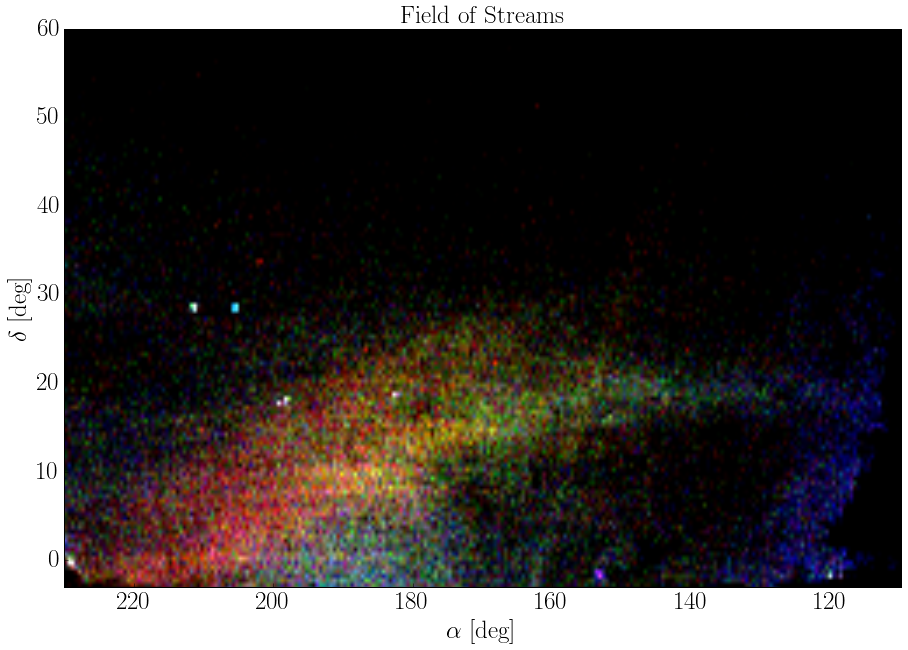

In [69]:
# Plot
fig, ax = plt.subplots(figsize=(15,10))
img = ax.imshow(rgb.T, origin='lower', extent=(ra[0], ra[-1], dec[0], dec[-1]), aspect='auto')
ax.set_xlim(230,110) 
ax.set_ylim(-3,60)
ax.set_xlabel(r'$\alpha$ [deg]') 
ax.set_ylabel(r'$\delta$ [deg]')
ax.set_title('Field of Streams')
fig.show()